In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install dwave-system
!pip install pandas-datareader --upgrade

In [3]:
from ast import Return
from itertools import product
import json
import random
import numpy as np
import pandas as pd
import os
import sys
import time
import yaml
from pandas_datareader.data import DataReader
import datetime as dt
from dimod import Integer, Binary
from dimod import quicksum
from dimod import ConstrainedQuadraticModel, DiscreteQuadraticModel
from dwave.system import LeapHybridDQMSampler, LeapHybridCQMSampler
from dimod import ExactSolver, ExactCQMSolver
import gc
import matplotlib
import seaborn as sns
from itertools import takewhile, count
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults
from IPython.display import clear_output
from typing import NamedTuple
from datetime import timedelta, datetime
import yfinance as yf

try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt


class SinglePeriod:
    def __init__(
        self,
        data,
        preds,
        budget,
        init_budget,
        sampler_args,
        dates,
        model_type,
        alpha,
        verbose,
        t_cost,
        label,
        init_holdings):

        self.df = data
        self.preds = preds
        self.budget = budget
        self.dates = dates
        self.model_type = model_type
        self.verbose = verbose
        self.t_cost = t_cost
        self.label = label
        self.init_budget = budget

        #print('self.df.columns')
        #print(self.df.columns)
        self.stocks = self.df.columns.tolist()
        self.init_holdings = init_holdings
        #print(f'self.init_holdings in single period: {init_holdings}')

        self.pct_returns = self.df.pct_change()

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")
        #print(f'self.alpha: {self.alpha}')

        self.model = {'CQM': None, 'DQM': None}

        self.sample_set = {}
        if sampler_args:
            self.sampler_args = json.loads(str(sampler_args))
        else:
            self.sampler_args = {}

        self.sampler = {'CQM': LeapHybridCQMSampler(**self.sampler_args), 'Exact': ExactCQMSolver()}
        self.solution = {}
        self.precision = 2


    def build_cqm(self, idx, max_risk=None, min_return=None):
        # Instantiating the CQM object
        cqm = ConstrainedQuadraticModel()
        self.max_num_shares = (self.budget/self.df.loc[idx,:]).astype(int)

        # Defining and adding variables to the CQM model
        x = {s: Integer("%s" %s, lower_bound=0, upper_bound=self.max_num_shares[s]) for s in self.stocks}

        print(f'idx in single period: {idx}')
        self.price = self.df.loc[idx, :]
        print('price')
        display(self.price)
        self.daily_returns = self.pct_returns.loc[:idx, :]
        print('daily returns')
        display(self.daily_returns)
        self.avg_daily_returns = self.preds.pct_change().loc[idx, :]
        print('avg daily returns')
        display(self.avg_daily_returns)
        self.covariance_matrix = self.daily_returns.cov()

        # Defining risk expression
        risk = 0
        for s1, s2 in product(self.stocks, self.stocks):
            coeff = (self.covariance_matrix[s1][s2] * self.price[s1] * self.price[s2])
            risk = risk + coeff*x[s1]*x[s2]

        print(f'risk: {risk}')

        returns = 0
        for s in self.stocks:
            returns = returns + self.price[s] * self.avg_daily_returns[s] * x[s]

        print(f'returns: {returns}')

        if not self.t_cost:
            print('t_cost False')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) <= self.budget, label='upper_budget')
            cqm.add_constraint(quicksum([x[s]*self.price[s] for s in self.stocks]) >= 0.997*self.budget, label='lower_budget')
        else:
            print('t_cost True')
            # Modeling transaction cost
            x0 = self.init_holdings
            print(f'init holdings total value: {sum([self.price[s]*self.init_holdings[s] for s in self.stocks])}')
            #self.budget = sum([self.price[s]*self.init_holdings[s] for s in self.stocks])
            # y indicates stock allocations that changed
            y = {s: Binary("Y[%s]" %s) for s in self.stocks}

            lhs = 0
            for s in self.stocks:
                lhs = lhs + 2*self.t_cost*self.price[s]*x[s]*y[s] + self.price[s]*(1 - self.t_cost)*x[s] \
                      - 2*self.t_cost*self.price[s]*x0[s]*y[s] - self.price[s]*(1 - self.t_cost)*x0[s]

            print(f't_cost: {self.t_cost}')

            print(f'budget in cqm: {self.budget}')
            print(f'lower bound: {self.budget - 0.003*self.init_budget}')

            cqm.add_constraint(lhs <= self.budget, label='upper_budget')
            cqm.add_constraint(lhs >= self.budget - 0.003*self.init_budget, label='lower_budget')

            # indicator constraints
            for s in self.stocks:
                cqm.add_constraint(x[s] - x0[s]*y[s] >= 0, label=f'indicator_constraint_gte_{s}')
                cqm.add_constraint(x[s] - x[s]*y[s] <= x0[s], label=f'indicator_constraint_lte_{s}')


        if max_risk:
            # Adding maximum risk constraint
            cqm.add_constraint(risk <= max_risk, label='max_risk')

            # Objective: maximize return
            cqm.set_objective(-1*returns)
        elif min_return:
            # Adding minimum returns constraint
            cqm.add_constraint(returns >= min_return, label='min_return')

            # Objective: minimize risk
            cqm.set_objective(risk)
        else:
            # Objective: minimize mean-variance expression
            #print('cqm debugging')
            # print(f'risk: {type(risk)}')
            # print(f'returns: {type(returns)}')
            #print(returns)

            cqm.set_objective(self.alpha * risk - returns)

        cqm.substitute_self_loops()

        self.model['CQM'] = cqm
        return self.model



    def solve_cqm(self, idx, max_risk=None, min_return=None):
        self.model = self.build_cqm(idx, max_risk, min_return)

        if self.model_type == 'CQM':
            self.sample_set['CQM'] = self.sampler['CQM'].sample_cqm(self.model['CQM'], label=self.label)
        else:
            gc.collect()
            self.sample_set['CQM'] = self.sampler['Exact'].sample_cqm(self.model['CQM'])

        n_samples = len(self.sample_set['CQM'].record)
        print(f'n_samples: {n_samples}')
        feasible_samples = self.sample_set['CQM'].filter(lambda d: d.is_feasible)

        if not feasible_samples:
            raise Exception("No feasible solution could be found for this problem instance.")
        else:
            best_feasible = feasible_samples.first

            solution = {}
            solution['stocks'] = {k:int(best_feasible.sample[k]) for k in self.stocks}
            print(f'solution_stocks: {solution["stocks"]}')
            solution['return'], solution['risk'] = self.compute_risk_and_returns(solution['stocks'])
            print(f'solution_return: {solution["return"]}')
            print(f'solution_risk: {solution["risk"]}')
            spending = sum([self.price[s]*max(0, solution['stocks'][s] - self.init_holdings[s]) for s in self.stocks])
            print(f'spending: {spending}')
            sales = sum([self.price[s]*max(0, self.init_holdings[s] - solution['stocks'][s]) for s in self.stocks])
            print(f'sales: {sales}')

            transaction = self.t_cost*(spending + sales)
            print(f'transaction: {transaction}')

            if self.verbose:
                print(f'Number of feasible solutions: {len(feasible_samples)} out of {n_samples} sampled.')
                print(f'\nBest energy: {self.sample_set["CQM"].first.energy: .2f}')
                print(f'Best energy (feasible): {best_feasible.energy: .2f}')

            print(f"\nEstimated Returns: {solution['return']}")
            print(f"Sales Revenue: {sales:.2f}")
            print(f"Purchase Cost: {spending:.2f}")
            print(f"Transaction Cost: {transaction:.2f}")
            print(f"Variance: {solution['risk']}\n")

            print(f'solution: {solution}')
            return solution


    def compute_risk_and_returns(self, solution):
        """Compute the risk and return values of solution.
        """
        variance = 0.0
        for s1, s2 in product(solution, solution):
            #print(f'stock: {stock}, price1: {self.price[s1]}, price2: {self.price[s2]}, covariance_matrix: {self.covariance_matrix[s1][s2]}')
            variance += (solution[s1] * self.price[s1] * solution[s2] * self.price[s2] * self.covariance_matrix[s1][s2])

        est_return = 0
        #tmp_daily_retuns = self.avg_daily_returns.loc[idx, :]
        for stock in solution:
            #print(f'stock: {stock}, price: {self.price[stock]}, avg_daily_returns: {self.avg_daily_returns[stock]}')
            est_return += solution[stock]*self.price[stock]*self.avg_daily_returns[stock]
            #est_return += solution[stock]*self.price[stock]*self.tmp_daily_returns[stock]

        return round(est_return, 2), round(variance, 2)

    def run(self, min_return=0, max_risk=0):

        return self.solve_cqm(min_return=min_return, max_risk=max_risk)

In [4]:
class MultiPeriod():
    """Solve the multi-period (dynamic) portfolio optimization problem.
    """
    def __init__(self,
                data,
                forecast,
                baseline,
                budget,
                sampler_args,
                dates,
                file_path,
                model_type,
                alpha,
                verbose,
                t_cost,
                label,
                init_holdings,
                save_path):

        self.save_path = save_path
        self.df = data
        self.preds = forecast
        print('self.preds')
        display(self.preds)
        self.stocks = self.df.columns.values.tolist()

        self.sampler_args = sampler_args
        self.budget = budget
        self.init_budget = budget
        self.sampler_args = sampler_args
        self.verbose = verbose
        self.label = label
        self.t_cost = t_cost
        self.baseline = baseline
        self.dates = dates
        self.model_type = model_type

        initial_gspc = self.baseline.query('ds==@dates[0]').values.tolist()[0][0]
        # print('initial baseline')
        # display(self.baseline)
        # print(f'initial_gspc: {initial_gspc}')
        self.baseline.iloc[:,0] = (self.baseline.iloc[:,0] / initial_gspc - 1)
        # print('final baseline')
        # display(self.baseline)
        # print('initial data')
        # display(self.df.head())

        self.init_holdings = init_holdings
        # if init_holdings is not None:
        #     self.init_holdings = init_holdings
        # else:
        #     self.init_holdings = {s:0 for s in self.stocks}

        # print('iniital_holdings')
        # print(self.init_holdings)

        if isinstance(alpha, (list, tuple)):
            self.alpha = alpha[0]
            self.alpha_list = list(alpha)
        elif isinstance (alpha, (int, float)):
            self.alpha = alpha
        else:
            raise TypeError("Use integer or float for alpha, or a list or tuple of either type.")

        # print('init holdings keys')
        # print(set(self.init_holdings.keys()))
        #self.stocks = list(set(self.df.columns.values.tolist()).intersection(set(self.init_holdings.keys())))
        self.stocks = self.df.columns.values.tolist()
        self.df = self.df.loc[:, self.stocks].copy()
        self.active_data = self.df.loc[dates[0]:,:]
        self.result = pd.DataFrame(columns=self.stocks)
        self.sample_set = {}
        self.sampler_args = sampler_args
        self.solution = {}

    def run(self, max_risk=0, min_return=0, num=0):
        """Solve the rebalancing portfolio optimization problem.
        Args:
            max_risk (int): Maximum risk for the CQM risk bounding formulation.
            min_return (int): Minimum return for the CQM return bounding formulation.
        """

        num_days = self.active_data.shape[0]
        print(f'num_days: {num_days}')
        first_purchase = True
        #result = {}
        #baseline_result = {}
        #days = []

        # dataframe to save output data
        headers = self.stocks
        self.output = pd.DataFrame(columns=headers)
        self.agg_results = pd.DataFrame(columns=['idx', 'variance', 'est_returns', 'value'])


        for idx, row in self.active_data.iterrows():
            print(f'idx: {idx}')

            previous_idx = idx - timedelta(days=1)
            self.price = self.df.loc[idx, :]
            print('price')
            display(self.price)
            baseline_current = self.baseline.loc[idx, :]

            if first_purchase:
                self.budget = self.init_budget
                #self.agg_results = pd.DataFrame([{'idx': idx, 'variance': 0.0, 'est_returns': 0.0, 'value': sum([self.price[s]*self.init_holdings[s] for s in self.stocks])}])

                print('preds')
                display(self.preds.loc[idx, :])
                print(f'budget in Multiperiod: {self.budget}')

                first_purchase = False
            else:
                self.budget = sum([self.price[s] * self.init_holdings[s] for s in self.stocks])
                print(f'budget in Multiperiod: {self.budget}')

            single_period = SinglePeriod(data=self.df.loc[:idx, :],
                                            preds=self.preds,
                                            budget=self.budget,
                                            init_budget = self.init_budget,
                                            sampler_args=self.sampler_args,
                                            dates=self.dates,
                                            model_type=self.model_type,
                                            alpha=self.alpha,
                                            verbose=self.verbose,
                                            t_cost=self.t_cost,
                                            label=self.label,
                                            init_holdings=self.init_holdings)
            baseline_shares = (self.budget / baseline_current)
            #display(self.baseline)
            self.solution = single_period.solve_cqm(idx, max_risk=max_risk, min_return=min_return)
            self.init_holdings = self.solution['stocks']
            value = sum([self.price[s]*self.solution['stocks'][s] for s in self.stocks])
            print(f'value: {value}')
            returns = self.solution['return']
            variance = self.solution['risk']
            self.output = pd.concat([self.output, pd.DataFrame([{s: self.solution['stocks'][s] for s in self.stocks}])])
            self.agg_results = pd.concat([self.agg_results, pd.DataFrame([{'idx': idx, 'variance': variance, 'est_returns': returns, 'value': value}])])

            #initial_budget = self.agg_results['value'].values.tolist()[0]
            self.agg_results['value_norm'] = self.agg_results['value'] / self.budget - 1
            display(self.agg_results)

            # fig = plt.figure(figsize=(10.708,8.2))
            # sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
            # sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
            # plt.show()
            # print(f'\nRun completed.\n')

        return self.agg_results

In [5]:
def load_data(initial_date, dates, stocks, baseline):
    print(f"\nLoading live data from the web from Yahoo! finance", f"from {initial_date} to {dates[1]}...")

    # Read in daily data; resample to monthly
    print(f'reader initial date: {initial_date}')
    print(f'reader final_date: {dates[1]}')
    panel_data = DataReader(stocks, 'yahoo', initial_date, dates[1])
    df = pd.DataFrame(index=panel_data.index, columns=stocks)

    for i in stocks:
        df[i] = panel_data[[('Adj Close',  i)]]
    df.dropna(axis=1, inplace=True)

    # Read in baseline data; resample to monthly
    index_df = DataReader(baseline, 'yahoo', dates[0], dates[1])
    df_baseline = pd.DataFrame(index=index_df.index, columns=baseline)
    for i in baseline:
        df_baseline[i] = index_df[[('Adj Close',  i)]]

    return df, df_baseline

In [6]:
def predict_returns(df):
    result = {}
    df = df.copy()

    for i, column in enumerate(df.columns.values):
        train = df.loc[:, column]
        history = [x for x in train.values]
        pred = list()
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        result[column] = output[0]

    pred_df = pd.DataFrame([result])
    return pd.concat([df, pred_df])

In [7]:
# GA block
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if np.random.rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = np.random.randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if np.random.rand() < r_mut:
            inverse_s = ''

            for b in bitstring[i]:
                if b == '0':
                    inverse_s += '1'
                else:
                    inverse_s += '0'
            bitstring[i] = inverse_s
    return bitstring

def selection(pop, scores, k=3):
	# first random selection
	selection_ix = np.random.randint(len(pop))
	#print(selection_ix)
	for ix in np.random.randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	#print(f'selection ix: {selection_ix}')
	return pop[selection_ix]

def objective(x, daily_return):
    offset = 0
    #offset = 1000 if any([y<0 for y in x]) else 0
    return -1 * sum([d1 * d2 for d1,d2 in zip(x, list(daily_return))]) + offset

def sample_initial_pop(prices, n_pop, budget):
    pop = []
    total = 0
    #shares = np.random.randint(100, size=len(prices))
    score_report = []
    for i in range(n_pop):
        while True:
            factor = np.random.randint(10, size=1)

            shares = [int(factor[0] * i) for i in np.random.chisquare(1,len(prices))]
            #print(f'len shares: {len(shares)}')
            #print(f'len prices: {len(prices)}')
            #print(f'shares: {shares}')
            #print(f'prices: {prices}')
            #print('list zip')
            #print([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            total = sum([d1 * int(d2) for d1, d2 in zip(prices, shares)])
            print(total)
            if total <= budget and total > 0.6 * budget: break
        score_report.append(total)
        pop.append(shares)
    pop = np.array(pop)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(score_report)
    ax.set_title('scores')
    plt.show()
    return pop


def generate_initial_state(df, n_iter, r_cross, r_mut, n_pop, budget):
    prices = df.iloc[0, :].values.tolist()
    #print(f'prices: {prices}')
    pop = sample_initial_pop(prices, n_pop, budget)
    daily_return = df.pct_change().iloc[-1, :].values
    # keep track of best solution
    best, best_eval, best_total = 0, objective(pop[0], daily_return), 0
    # enumerate generations
    for gen in range(n_iter):
        print(gen)
        # evaluate all candidates in the population
        scores = [objective(c, daily_return) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best_total = sum([d1 * d2 for d1, d2 in zip(prices, pop[i])])
                best, best_eval  = pop[i], scores[i]

        selected = [selection(pop, scores).tolist() for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
        # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross): #.block_until_ready():
                # mutation
                m = mutation(["{0:b}".format(i) for i in c], r_mut)
                cm = [int(i, 2) for i in m]
                children.append(cm)

        # replace population
        pop = np.array(children)
        total = sum([d1 * d2 for d1, d2 in zip(prices, scores)])
        if gen % 10 == 0:
            total = np.dot(np.array(prices), np.array(pop).T)
            clear_output(wait=True)
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
            ax[0].hist(scores)
            ax[0].set_title('scores')
            ax[1].hist(total)
            ax[1].set_title('budget')
            plt.show()
            print(f'{gen} best eval:{best_eval}')
            print(f'mean score: {np.mean(scores)}')
            print(f'best total: {best_total}')

    print(f'best: {best}')
    print(f'best_eval: {best_eval}')
    print(f'best_total: {best_total}')
    names = df.columns.tolist()
    df = pd.DataFrame([[i,j] for i,j in zip(names, best)], columns=['a', 'b'])
    return df, best_total

In [8]:
initial_date = '2021-01-01'
end_date = '2021-07-01'
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
ticker_list = first_table['Symbol'].values.tolist()
source = yf.download(ticker_list, start=initial_date, end=end_date)[['Close']]
df_src = source.copy()
df_src.columns = df_src.columns.droplevel(0)
df_src.dropna(axis=1, inplace=True)
stock_list = df_src.columns.values.tolist()
df_src.reset_index(inplace=True)
df_src.rename(columns={'Date':'ds'}, inplace=True)
df_src.set_index('ds', inplace=True)
df_src.head()

[*********************100%%**********************]  503 of 503 completed

ERROR:yfinance:
4 Failed downloads:
ERROR:yfinance:['CEG', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1609477200, endDate = 1625112000")
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-01 -> 2021-07-01)')
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-04,118.639999,15.13,157.339996,129.410004,105.410004,96.500000,109.110001,34.900002,256.459991,485.339996,...,106.900002,65.660004,41.500000,53.750000,99.690002,105.820000,148.699036,378.130005,42.930000,163.589996
2021-01-05,119.610001,15.43,157.169998,131.009995,106.500000,97.760002,110.459999,35.040001,257.920013,485.690002,...,110.190002,65.019997,43.500000,55.290001,99.570000,105.830002,151.271851,380.570007,43.610001,164.729996
2021-01-06,122.889999,15.52,166.250000,126.599998,105.580002,106.169998,110.230003,36.580002,260.739990,466.309998,...,110.849998,66.459999,44.610001,57.959999,103.769997,106.410004,155.582520,394.820007,48.509998,167.149994
2021-01-07,126.160004,15.38,167.669998,130.919998,106.709999,110.129997,111.300003,36.240002,263.200012,477.739990,...,109.750000,65.160004,44.959999,57.660000,108.480003,105.599998,154.660187,409.100006,49.990002,167.000000
2021-01-08,127.059998,15.13,170.059998,132.050003,107.269997,110.029999,111.610001,36.439999,264.160004,485.100006,...,109.029999,65.760002,45.459999,58.180000,107.379997,107.150002,154.320389,405.470001,48.720001,168.110001


In [9]:
initial_date = '2021-01-01'
end_date = '2021-07-01'
source = yf.download(['^GSPC'], start=initial_date, end=end_date)[['Close']]
df_baseline = source.copy()
display(df_baseline.head())
df_baseline = source[['Close']]
df_baseline.dropna(axis=1, inplace=True)
df_baseline.reset_index(inplace=True)
df_baseline.rename(columns={'Date':'ds'}, inplace=True)
df_baseline.set_index('ds', inplace=True)
df_baseline.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


,Close
ds,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


In [10]:
load_path = '/content/drive/MyDrive/dwave/conf/'
pickle_file = '/content/drive/MyDrive/ga/df.pkl'
with open(load_path+'config.txt', 'r') as conf:
    cred = conf.readline().strip()

cfg = {'stocks': None,
            'dates': ["2021-06-01", "2021-07-01"],
            'initial_date': "2021-01-01",
            'budget': 1000,
            'bin_size': '',
            'gamma': '',
            'alpha': 1.0,
            'file_path': None,
            'baseline': ['^GSPC'],
            'max_risk': 0.0,
            'min_return': 0.0,
            'model_type': 'CQM',
            'rebalance': True,
            'sampler_args': cred,
            'verbose': False,
            'num': 0,
            't_cost': 0.0,
            'n_iter': 100,
            'r_cross': 0.8,
            'r_mut': 0.01,
            'n_pop': 1000,
            'label': 'Experiment 4',
            'init_holdings_path': '/content/drive/MyDrive/dwave/init_holdings.pkl',
            'calculation_type': 'daily',
            'save_path': '/content/drive/MyDrive/dwave/'
}

df_forecast_init = pd.read_pickle('/content/drive/MyDrive/models/lgbm_20_backtest.pkl')
df_forecast_init.index.names = ['ds']
print('df_forecast_init')
display(df_forecast_init.tail())
n_stocks = 6
stocks = df_forecast_init.columns.values.tolist()[:n_stocks]

# print('df')
# display(df.loc[:, stocks].shift(1).head())
# display(df.loc[:, stocks].shift(1).tail())
df = df_src.loc[:, stocks].shift(1)
df.dropna(inplace=True)
display(df.head())


#df_forecast = df_src.loc[:, stocks].copy()
df_forecast = pd.concat([df.loc[:(datetime.strptime(cfg['dates'][0], '%Y-%m-%d') - timedelta(days=1)), :], df_forecast_init.loc[:, stocks]], axis=0)


df_forecast_init


component,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ
ds,,,,,,,,,,,,,,,,,,,,
2021-06-24,144.533275,22.311011,200.618412,134.000369,114.444677,117.137398,110.770653,38.518082,286.168220,557.019597,163.760820,61.415389,195.987823,283.222162,82.608674,83.349458,25.624797,52.799280,47.613560,154.537456
2021-06-25,145.644250,22.329560,200.331560,133.175076,114.856547,116.654139,111.652757,38.897167,288.404758,558.395945,165.247477,61.819882,196.153547,287.207009,81.194616,83.090155,25.801721,52.910658,47.802288,155.703599
2021-06-28,144.867553,22.435920,202.416632,133.355656,113.439567,116.168338,112.102045,39.150949,291.016352,558.459812,166.915255,61.930524,196.802058,288.886774,81.919258,84.270725,26.230586,54.662100,49.180730,157.439943
2021-06-29,145.405624,21.009751,204.094801,134.260115,112.648726,114.900173,113.982671,38.643299,291.487102,570.658734,166.156724,61.283882,195.745522,295.854965,81.933233,85.141641,26.788827,53.393008,47.777303,156.951892
2021-06-30,146.019711,21.378169,204.518649,134.139080,112.492505,115.130130,114.293718,39.001348,291.728585,571.483641,168.679069,61.458320,195.428718,295.781137,80.670301,83.853520,26.031758,53.714718,47.578363,156.551092


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,118.639999,15.13,157.339996,129.410004,105.410004,96.500000
2021-01-06,119.610001,15.43,157.169998,131.009995,106.500000,97.760002
2021-01-07,122.889999,15.52,166.250000,126.599998,105.580002,106.169998
2021-01-08,126.160004,15.38,167.669998,130.919998,106.709999,110.129997
2021-01-11,127.059998,15.13,170.059998,132.050003,107.269997,110.029999


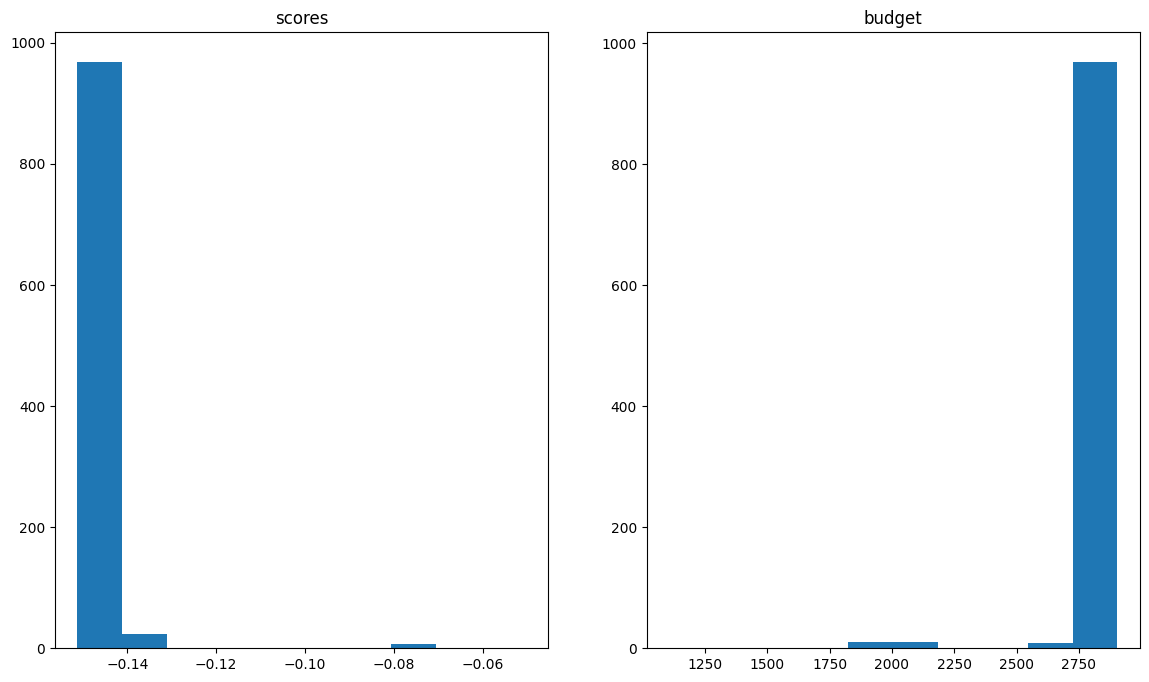

90 best eval:-0.15126966218365556
mean score: -0.15003471972331087
best total: 2799.029998779297
91
92
93
94
95
96
97
98
99
best: [8 0 6 7 0 0]
best_eval: -0.15126966218365556
best_total: 2799.029998779297
pop: [8, 0, 6, 7, 0, 0]


In [11]:
init_holdings_df, budget = generate_initial_state(df, cfg['n_iter'], cfg['r_cross'], cfg['r_mut'], cfg['n_pop'], cfg['budget'])
init_holdings_df.to_pickle(cfg['save_path']+'init_holdings.pkl')

#init_holdings_df = pd.read_pickle(cfg['save_path']+'init_holdings.pkl')
init_holdings = {}

for idx, row in init_holdings_df.iterrows():
    init_holdings.update({row['a']: row['b']})

prices = df.loc[cfg['dates'][0], :].values.tolist()
pop = init_holdings_df['b'].values.tolist()
print(f'pop: {pop}')
budget = sum([d1 * d2 for d1, d2 in zip(prices, pop)])

In [12]:
# fig = plt.figure(figsize=(10.708,8.2))
# sns.scatterplot(x='ds', y=df_forecast_init.sum(axis=1), data=df_forecast_init, label='Forecast')
# sns.scatterplot(x='ds', y=df.sum(axis=1), data=df.loc['2021-06-01':, :], label='Ground Truth')
# # sns.scatterplot(x='Date', y='^GSPC', data=self.baseline, label='Fund Portfolio')
# # sns.scatterplot(x='idx', y='value_norm', data=self.agg_results, label='Quantum')
# plt.show()

In [13]:
my_portfolio = MultiPeriod(data=df,
                        forecast=df_forecast,
                        baseline=df_baseline,
                        budget=budget,
                        sampler_args=cfg['sampler_args'],
                        dates=cfg['dates'],
                        file_path=cfg['file_path'],
                        model_type=cfg['model_type'],
                        alpha=cfg['alpha'],
                        verbose=cfg['verbose'],
                        t_cost=cfg['t_cost'],
                        label=cfg['label'],
                        init_holdings=init_holdings,
                        save_path=cfg['save_path']+cfg['label']+'/'
                        )

df_results = my_portfolio.run(min_return=cfg['min_return'], max_risk=cfg['max_risk'], num=cfg['num'])

self.preds


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,118.639999,15.130000,157.339996,129.410004,105.410004,96.500000
2021-01-06,119.610001,15.430000,157.169998,131.009995,106.500000,97.760002
2021-01-07,122.889999,15.520000,166.250000,126.599998,105.580002,106.169998
2021-01-08,126.160004,15.380000,167.669998,130.919998,106.709999,110.129997
2021-01-11,127.059998,15.130000,170.059998,132.050003,107.269997,110.029999
...,...,...,...,...,...,...
2021-06-24,144.533275,22.311011,200.618412,134.000369,114.444677,117.137398
2021-06-25,145.644250,22.329560,200.331560,133.175076,114.856547,116.654139
2021-06-28,144.867553,22.435920,202.416632,133.355656,113.439567,116.168338


num_days: 22
idx: 2021-06-01 00:00:00
price


A       138.130005
AAL      24.240000
AAP     189.729996
AAPL    124.610001
ABBV    113.199997
ABC     114.739998
Name: 2021-06-01 00:00:00, dtype: float64

preds


A       135.783294
AAL      24.246519
AAP     191.890420
AAPL    124.884786
ABBV    111.899694
ABC     115.806999
Name: 2021-06-01 00:00:00, dtype: float64

budget in Multiperiod: 3115.6900177001953
idx in single period: 2021-06-01 00:00:00
price


A       138.130005
AAL      24.240000
AAP     189.729996
AAPL    124.610001
ABBV    113.199997
ABC     114.739998
Name: 2021-06-01 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-05-25,0.007861,0.018609,-0.022007,0.013314,-0.001808,-0.012909
2021-05-26,-0.000825,0.009569,-0.013900,-0.001574,-0.011647,-0.029784
2021-05-27,0.000450,0.029729,0.005372,-0.000394,0.001222,-0.002696


avg daily returns


A      -0.012772
AAL    -0.007511
AAP     0.017231
AAPL   -0.003155
ABBV   -0.003742
ABC     0.006930
Name: 2021-06-01 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.8219217308581452, ('AAL', 'A'): 0.3004361348299089, ('AAL', 'AAL'): 0.5971390850627484, ('AAP', 'A'): 3.084812756080672, ('AAP', 'AAL'): 0.8922472870678483, ('AAP', 'AAP'): 12.782089303041534, ('AAPL', 'A'): 3.9318521004513696, ('AAPL', 'AAL'): -0.1564171703973175, ('AAPL', 'AAP'): -2.5542724808131565, ('AAPL', 'AAPL'): 5.345321915842802, ('ABBV', 'A'): 2.2908910988864575, ('ABBV', 'AAL'): 0.27292623060415466, ('ABBV', 'AAP'): 3.3461144535759546, ('ABBV', 'AAPL'): 1.945182821754805, ('ABBV', 'ABBV'): 2.491535566832447, ('ABC', 'A'): 1.676821151260838, ('ABC', 'AAL'): 0.08090225053616222, ('ABC', 'AAP'): 7.358718248229475, ('ABC', 'AAPL'): 0.54494554521395, ('ABC', 'ABBV'): 0.4236830363701479, ('ABC', 'ABC'): 4.543591451079316}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: QuadraticMo

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.04998,-0.000205


idx: 2021-06-02 00:00:00
price


A       137.199997
AAL      24.670000
AAP     194.649994
AAPL    124.279999
ABBV    112.209999
ABC     114.320000
Name: 2021-06-02 00:00:00, dtype: float64

budget in Multiperiod: 3113.929962158203
idx in single period: 2021-06-02 00:00:00
price


A       137.199997
AAL      24.670000
AAP     194.649994
AAPL    124.279999
ABBV    112.209999
ABC     114.320000
Name: 2021-06-02 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-05-26,-0.000825,0.009569,-0.013900,-0.001574,-0.011647,-0.029784
2021-05-27,0.000450,0.029729,0.005372,-0.000394,0.001222,-0.002696
2021-05-28,0.031885,0.022176,-0.001958,-0.012377,-0.020750,0.002878


avg daily returns


A       0.003534
AAL     0.011313
AAP    -0.006112
AAPL   -0.008487
ABBV   -0.003312
ABC    -0.002055
Name: 2021-06-02 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.7461312294742175, ('AAL', 'A'): 0.29374542603379994, ('AAL', 'AAL'): 0.6133308907988754, ('AAP', 'A'): 3.008005344024307, ('AAP', 'AAL'): 0.9506770565623233, ('AAP', 'AAP'): 13.532589944430853, ('AAPL', 'A'): 3.8632875702193203, ('AAPL', 'AAL'): -0.15904487573611703, ('AAPL', 'AAP'): -2.61540379244957, ('AAPL', 'AAPL'): 5.2653083603576665, ('ABBV', 'A'): 2.257271953413547, ('ABBV', 'AAL'): 0.2660995756571512, ('ABBV', 'AAP'): 3.2714301494685154, ('ABBV', 'AAPL'): 1.9104068956976743, ('ABBV', 'ABBV'): 2.435162692335244, ('ABC', 'A'): 1.6572257388142577, ('ABC', 'AAL'): 0.07737070873642064, ('ABC', 'AAP'): 7.389608216381345, ('ABC', 'AAPL'): 0.5399273017923569, ('ABC', 'ABBV'): 0.42761509122205366, ('ABC', 'ABC'): 4.4696714309943895}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadra

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.000360
0,2021-06-02,939.39,-6.27,3109.069967,-0.001561


idx: 2021-06-03 00:00:00
price


A       136.570007
AAL      25.820000
AAP     191.330002
AAPL    125.059998
ABBV    111.400002
ABC     115.120003
Name: 2021-06-03 00:00:00, dtype: float64

budget in Multiperiod: 3111.9100494384766
idx in single period: 2021-06-03 00:00:00
price


A       136.570007
AAL      25.820000
AAP     191.330002
AAPL    125.059998
ABBV    111.400002
ABC     115.120003
Name: 2021-06-03 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-05-27,0.000450,0.029729,0.005372,-0.000394,0.001222,-0.002696
2021-05-28,0.031885,0.022176,-0.001958,-0.012377,-0.020750,0.002878
2021-06-01,0.004290,-0.007777,0.005778,-0.005348,0.007835,-0.002348


avg daily returns


A      -0.011707
AAL     0.012778
AAP     0.001244
AAPL    0.007863
ABBV    0.000136
ABC     0.003374
Name: 2021-06-03 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.682191618844847, ('AAL', 'A'): 0.2857224888633553, ('AAL', 'AAL'): 0.6763082528903048, ('AAP', 'A'): 2.974230770134162, ('AAP', 'AAL'): 0.8918531302668526, ('AAP', 'AAP'): 13.079394308772791, ('AAPL', 'A'): 3.818552397376063, ('AAPL', 'AAL'): -0.14901159723971602, ('AAPL', 'AAP'): -2.6199545508825155, ('AAPL', 'AAPL'): 5.285760056209415, ('ABBV', 'A'): 2.223143488867383, ('ABBV', 'AAL'): 0.25548681465798984, ('ABBV', 'AAP'): 3.224519794740888, ('ABBV', 'AAPL'): 1.8758596349639705, ('ABBV', 'ABBV'): 2.3841752805614185, ('ABC', 'A'): 1.6352247377581417, ('ABC', 'AAL'): 0.09306856224337878, ('ABC', 'AAP'): 7.199985061532559, ('ABC', 'AAPL'): 0.5511502403902445, ('ABC', 'ABBV'): 0.41310539963579507, ('ABC', 'ABC'): 4.491447604263279}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadrati

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.001009
0,2021-06-02,939.39,-6.27,3109.069967,-0.000913
0,2021-06-03,933.42,6.27,3104.690033,-0.002320


idx: 2021-06-04 00:00:00
price


A       136.369995
AAL      24.930000
AAP     191.139999
AAPL    123.540001
ABBV    112.209999
ABC     116.800003
Name: 2021-06-04 00:00:00, dtype: float64

budget in Multiperiod: 3101.5400009155273
idx in single period: 2021-06-04 00:00:00
price


A       136.369995
AAL      24.930000
AAP     191.139999
AAPL    123.540001
ABBV    112.209999
ABC     116.800003
Name: 2021-06-04 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-05-28,0.031885,0.022176,-0.001958,-0.012377,-0.020750,0.002878
2021-06-01,0.004290,-0.007777,0.005778,-0.005348,0.007835,-0.002348
2021-06-02,-0.006733,0.017739,0.025932,-0.002648,-0.008746,-0.003660


avg daily returns


A       0.002772
AAL    -0.002359
AAP     0.001175
AAPL   -0.000944
ABBV    0.003962
ABC     0.005031
Name: 2021-06-04 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.6373042041895562, ('AAL', 'A'): 0.2804892820155398, ('AAL', 'AAL'): 0.6340084441449609, ('AAP', 'A'): 2.9426303555360684, ('AAP', 'AAL'): 0.86320742530933, ('AAP', 'AAP'): 12.930010253330853, ('AAPL', 'A'): 3.741428150071202, ('AAPL', 'AAL'): -0.1122235759468937, ('AAPL', 'AAP'): -2.543719855008465, ('AAPL', 'AAPL'): 5.129069951447265, ('ABBV', 'A'): 2.208596183903419, ('ABBV', 'AAL'): 0.23171704152706044, ('ABBV', 'AAP'): 3.2048296511487306, ('ABBV', 'AAPL'): 1.8271944782606022, ('ABBV', 'ABBV'): 2.4008224911980673, ('ABC', 'A'): 1.6291653527707968, ('ABC', 'AAL'): 0.06169192533767033, ('ABC', 'AAP'): 7.2101900597707616, ('ABC', 'AAPL'): 0.5047378253880477, ('ABC', 'ABBV'): 0.439353825553086, ('ABC', 'ABC'): 4.599808617879044}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: QuadraticM

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.004356
0,2021-06-02,939.39,-6.27,3109.069967,0.002428
0,2021-06-03,933.42,6.27,3104.690033,0.001016
0,2021-06-04,914.03,7.55,3098.129990,-0.001099


idx: 2021-06-07 00:00:00
price


A       137.899994
AAL      24.299999
AAP     192.759995
AAPL    125.889999
ABBV    112.360001
ABC     116.919998
Name: 2021-06-07 00:00:00, dtype: float64

budget in Multiperiod: 3112.299949645996
idx in single period: 2021-06-07 00:00:00
price


A       137.899994
AAL      24.299999
AAP     192.759995
AAPL    125.889999
ABBV    112.360001
ABC     116.919998
Name: 2021-06-07 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-01,0.004290,-0.007777,0.005778,-0.005348,0.007835,-0.002348
2021-06-02,-0.006733,0.017739,0.025932,-0.002648,-0.008746,-0.003660
2021-06-03,-0.004592,0.046615,-0.017056,0.006276,-0.007219,0.006998


avg daily returns


A       0.012330
AAL    -0.012290
AAP     0.005633
AAPL    0.008408
ABBV   -0.000566
ABC     0.002653
Name: 2021-06-07 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.700947155218335, ('AAL', 'A'): 0.25471482606233925, ('AAL', 'AAL'): 0.6018372937201335, ('AAP', 'A'): 3.0038443123186553, ('AAP', 'AAL'): 0.8228286324696978, ('AAP', 'AAP'): 13.038288700933837, ('AAPL', 'A'): 3.880740186112491, ('AAPL', 'AAL'): -0.14479322738442651, ('AAPL', 'AAP'): -2.5315982199431453, ('AAPL', 'AAPL'): 5.331080574092813, ('ABBV', 'A'): 2.2167061782419846, ('ABBV', 'AAL'): 0.22297024372193563, ('ABBV', 'AAP'): 3.2068918806299207, ('ABBV', 'AAPL'): 1.8498433673592822, ('ABBV', 'ABBV'): 2.3841482903140268, ('ABC', 'A'): 1.6303494266821639, ('ABC', 'AAL'): 0.06122988061921936, ('ABC', 'AAP'): 7.206090955397098, ('ABC', 'AAPL'): 0.5046394424408722, ('ABC', 'ABBV'): 0.43600232709480063, ('ABC', 'ABC'): 4.565068709371475}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quad

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.000884
0,2021-06-02,939.39,-6.27,3109.069967,-0.001038
0,2021-06-03,933.42,6.27,3104.690033,-0.002445
0,2021-06-04,914.03,7.55,3098.129990,-0.004553
0,2021-06-07,910.17,11.22,3106.549957,-0.001848


idx: 2021-06-08 00:00:00
price


A       137.649994
AAL      24.250000
AAP     193.009995
AAPL    125.900002
ABBV    113.010002
ABC     118.260002
Name: 2021-06-08 00:00:00, dtype: float64

budget in Multiperiod: 3117.8500061035156
idx in single period: 2021-06-08 00:00:00
price


A       137.649994
AAL      24.250000
AAP     193.009995
AAPL    125.900002
ABBV    113.010002
ABC     118.260002
Name: 2021-06-08 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-02,-0.006733,0.017739,0.025932,-0.002648,-0.008746,-0.003660
2021-06-03,-0.004592,0.046615,-0.017056,0.006276,-0.007219,0.006998
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154,0.007271,0.014593


avg daily returns


A       0.000380
AAL     0.001623
AAP     0.005577
AAPL    0.003174
ABBV    0.000440
ABC     0.001873
Name: 2021-06-08 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.654418795133471, ('AAL', 'A'): 0.25280375071626976, ('AAL', 'AAL'): 0.5939328911542284, ('AAP', 'A'): 2.97505579789797, ('AAP', 'AAL'): 0.814877940913606, ('AAP', 'AAP'): 12.947866156272763, ('AAPL', 'A'): 3.8369252035535073, ('AAPL', 'AAL'): -0.1432021300782204, ('AAPL', 'AAP'): -2.5110047457806317, ('AAPL', 'AAPL'): 5.2811520787904, ('ABBV', 'A'): 2.1993056684599837, ('ABBV', 'AAL'): 0.21980719898888165, ('ABBV', 'AAP'): 3.19716916149855, ('ABBV', 'AAPL'): 1.8432112356806247, ('ABBV', 'ABBV'): 2.391955181343127, ('ABC', 'A'): 1.6206468691794822, ('ABC', 'AAL'): 0.05758963436699019, ('ABC', 'AAP'): 7.225313176032321, ('ABC', 'AAPL'): 0.506069108066136, ('ABC', 'ABBV'): 0.45145974490828844, ('ABC', 'ABC'): 4.637654794309532}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: QuadraticMode

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.000898
0,2021-06-02,939.39,-6.27,3109.069967,-0.002816
0,2021-06-03,933.42,6.27,3104.690033,-0.004221
0,2021-06-04,914.03,7.55,3098.129990,-0.006325
0,2021-06-07,910.17,11.22,3106.549957,-0.003624
0,2021-06-08,907.51,5.96,3112.600006,-0.001684


idx: 2021-06-09 00:00:00
price


A       138.750000
AAL      24.219999
AAP     197.869995
AAPL    126.739998
ABBV    112.339996
ABC     117.900002
Name: 2021-06-09 00:00:00, dtype: float64

budget in Multiperiod: 3122.10994720459
idx in single period: 2021-06-09 00:00:00
price


A       138.750000
AAL      24.219999
AAP     197.869995
AAPL    126.739998
ABBV    112.339996
ABC     117.900002
Name: 2021-06-09 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-03,-0.004592,0.046615,-0.017056,0.006276,-0.007219,0.006998
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154,0.007271,0.014593
2021-06-07,0.011219,-0.025271,0.008475,0.019022,0.001337,0.001027


avg daily returns


A       0.001152
AAL    -0.006148
AAP     0.025949
AAPL    0.002677
ABBV    0.002180
ABC     0.012773
Name: 2021-06-09 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.685614981121643, ('AAL', 'A'): 0.24958297846398692, ('AAL', 'AAL'): 0.5870850686263431, ('AAP', 'A'): 3.1222298718115944, ('AAP', 'AAL'): 0.8136936105770312, ('AAP', 'AAP'): 13.674639658044171, ('AAPL', 'A'): 3.871101636034324, ('AAPL', 'AAL'): -0.1450243890266192, ('AAPL', 'AAP'): -2.493761166887192, ('AAPL', 'AAPL'): 5.3082421937701, ('ABBV', 'A'): 2.1703132047803027, ('ABBV', 'AAL'): 0.2182778296319036, ('ABBV', 'AAP'): 3.1634574298587315, ('ABBV', 'AAPL'): 1.8150794852330878, ('ABBV', 'ABBV'): 2.3466397958115786, ('ABC', 'A'): 1.603082957472294, ('ABC', 'AAL'): 0.05849633321442865, ('ABC', 'AAP'): 7.263439129796744, ('ABC', 'AAPL'): 0.49341440730588243, ('ABC', 'ABBV'): 0.4516734794452614, ('ABC', 'ABC'): 4.569391356341827}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: QuadraticM

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.002261
0,2021-06-02,939.39,-6.27,3109.069967,-0.004177
0,2021-06-03,933.42,6.27,3104.690033,-0.005580
0,2021-06-04,914.03,7.55,3098.129990,-0.007681
0,2021-06-07,910.17,11.22,3106.549957,-0.004984
0,2021-06-08,907.51,5.96,3112.600006,-0.003046
0,2021-06-09,898.12,20.71,3115.459955,-0.002130


idx: 2021-06-10 00:00:00
price


A       140.130005
AAL      23.850000
AAP     197.029999
AAPL    127.129997
ABBV    114.000000
ABC     117.400002
Name: 2021-06-10 00:00:00, dtype: float64

budget in Multiperiod: 3129.0500164031982
idx in single period: 2021-06-10 00:00:00
price


A       140.130005
AAL      23.850000
AAP     197.029999
AAPL    127.129997
ABBV    114.000000
ABC     117.400002
Name: 2021-06-10 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-04,-0.001465,-0.034469,-0.000993,-0.012154,0.007271,0.014593
2021-06-07,0.011219,-0.025271,0.008475,0.019022,0.001337,0.001027
2021-06-08,-0.001813,-0.002058,0.001297,0.000079,0.005785,0.011461


avg daily returns


A       0.010769
AAL    -0.019609
AAP     0.004347
AAPL    0.010700
ABBV    0.001098
ABC    -0.009832
Name: 2021-06-10 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.7369482443546627, ('AAL', 'A'): 0.2354243872332346, ('AAL', 'AAL'): 0.5661075619692073, ('AAP', 'A'): 3.082411773399835, ('AAP', 'AAL'): 0.8019252456537828, ('AAP', 'AAP'): 13.447546539989894, ('AAPL', 'A'): 3.8935834724786114, ('AAPL', 'AAL'): -0.145430372138949, ('AAPL', 'AAP'): -2.4769996562095966, ('AAPL', 'AAPL'): 5.292491515970255, ('ABBV', 'A'): 2.238453748703403, ('ABBV', 'AAL'): 0.20177155517922113, ('ABBV', 'AAP'): 3.128242069685389, ('ABBV', 'AAPL'): 1.842054452367281, ('ABBV', 'ABBV'): 2.417803231328397, ('ABC', 'A'): 1.581060179786871, ('ABC', 'AAL'): 0.06338638937297254, ('ABC', 'AAP'): 7.152265604419547, ('ABC', 'AAPL'): 0.48283629023654573, ('ABC', 'ABBV'): 0.43022575553206915, ('ABC', 'ABC'): 4.49339980359806}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: QuadraticMo

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.004474
0,2021-06-02,939.39,-6.27,3109.069967,-0.006385
0,2021-06-03,933.42,6.27,3104.690033,-0.007785
0,2021-06-04,914.03,7.55,3098.129990,-0.009882
0,2021-06-07,910.17,11.22,3106.549957,-0.007191
0,2021-06-08,907.51,5.96,3112.600006,-0.005257
0,2021-06-09,898.12,20.71,3115.459955,-0.004343
0,2021-06-10,893.48,4.86,3119.850023,-0.002940


idx: 2021-06-11 00:00:00
price


A       143.059998
AAL      23.459999
AAP     195.850006
AAPL    126.110001
ABBV    116.239998
ABC     120.940002
Name: 2021-06-11 00:00:00, dtype: float64

budget in Multiperiod: 3161.349983215332
idx in single period: 2021-06-11 00:00:00
price


A       143.059998
AAL      23.459999
AAP     195.850006
AAPL    126.110001
ABBV    116.239998
ABC     120.940002
Name: 2021-06-11 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-07,0.011219,-0.025271,0.008475,0.019022,0.001337,0.001027
2021-06-08,-0.001813,-0.002058,0.001297,0.000079,0.005785,0.011461
2021-06-09,0.007991,-0.001237,0.025180,0.006672,-0.005929,-0.003044


avg daily returns


A      -0.000768
AAL    -0.019220
AAP    -0.023627
AAPL   -0.010167
ABBV    0.029466
ABC     0.020865
Name: 2021-06-11 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.9285283392862484, ('AAL', 'A'): 0.2092321882318528, ('AAL', 'AAL'): 0.5449126918400486, ('AAP', 'A'): 3.0173580287580903, ('AAP', 'AAL'): 0.7914684242714172, ('AAP', 'AAP'): 13.187855170317793, ('AAPL', 'A'): 3.8554222214021356, ('AAPL', 'AAL'): -0.13142033741313933, ('AAPL', 'AAP'): -2.389823737163668, ('AAPL', 'AAPL'): 5.169071345228281, ('ABBV', 'A'): 2.4193161976611353, ('ABBV', 'AAL'): 0.1806539160934041, ('ABBV', 'AAP'): 3.0763903395431953, ('ABBV', 'AAPL'): 1.8053033492203348, ('ABBV', 'ABBV'): 2.5344318069304728, ('ABC', 'A'): 1.8197830231104537, ('ABC', 'AAL'): 0.03274105566924104, ('ABC', 'AAP'): 7.155017318801631, ('ABC', 'AAPL'): 0.4255904866712663, ('ABC', 'ABBV'): 0.5845847621476775, ('ABC', 'ABC'): 4.830850665317979}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadra

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.014646
0,2021-06-02,939.39,-6.27,3109.069967,-0.016537
0,2021-06-03,933.42,6.27,3104.690033,-0.017923
0,2021-06-04,914.03,7.55,3098.129990,-0.019998
0,2021-06-07,910.17,11.22,3106.549957,-0.017334
0,2021-06-08,907.51,5.96,3112.600006,-0.015421
0,2021-06-09,898.12,20.71,3115.459955,-0.014516
0,2021-06-10,893.48,4.86,3119.850023,-0.013127
0,2021-06-11,919.18,28.74,3157.989983,-0.001063


idx: 2021-06-14 00:00:00
price


A       143.529999
AAL      23.530001
AAP     199.440002
AAPL    127.349998
ABBV    115.419998
ABC     119.839996
Name: 2021-06-14 00:00:00, dtype: float64

budget in Multiperiod: 3156.239963531494
idx in single period: 2021-06-14 00:00:00
price


A       143.529999
AAL      23.530001
AAP     199.440002
AAPL    127.349998
ABBV    115.419998
ABC     119.839996
Name: 2021-06-14 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-08,-0.001813,-0.002058,0.001297,0.000079,0.005785,0.011461
2021-06-09,0.007991,-0.001237,0.025180,0.006672,-0.005929,-0.003044
2021-06-10,0.009946,-0.015277,-0.004245,0.003077,0.014777,-0.004241


avg daily returns


A       0.005239
AAL    -0.000330
AAP     0.027183
AAPL    0.012506
ABBV   -0.008713
ABC    -0.015337
Name: 2021-06-14 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.918510626434786, ('AAL', 'A'): 0.20847593295246214, ('AAL', 'AAL'): 0.5431521753005165, ('AAP', 'A'): 3.066847725902212, ('AAP', 'AAL'): 0.7988540848977588, ('AAP', 'AAP'): 13.644602114616825, ('AAPL', 'A'): 3.875131881832222, ('AAPL', 'AAL'): -0.13271435798633424, ('AAPL', 'AAP'): -2.361116776491427, ('AAPL', 'AAPL'): 5.237338564923023, ('ABBV', 'A'): 2.384464315704414, ('ABBV', 'AAL'): 0.1788727610171977, ('ABBV', 'AAP'): 3.0277624849271323, ('ABBV', 'AAPL'): 1.7722806944270295, ('ABBV', 'ABBV'): 2.4837151483089315, ('ABC', 'A'): 1.7873435589563775, ('ABC', 'AAL'): 0.03313142145058423, ('ABC', 'AAP'): 7.074146343215422, ('ABC', 'AAPL'): 0.39080566837476066, ('ABC', 'ABBV'): 0.5928306798185303, ('ABC', 'ABC'): 4.716616852138809}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadrati

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.013050
0,2021-06-02,939.39,-6.27,3109.069967,-0.014945
0,2021-06-03,933.42,6.27,3104.690033,-0.016333
0,2021-06-04,914.03,7.55,3098.129990,-0.018411
0,2021-06-07,910.17,11.22,3106.549957,-0.015743
0,2021-06-08,907.51,5.96,3112.600006,-0.013827
0,2021-06-09,898.12,20.71,3115.459955,-0.012920
0,2021-06-10,893.48,4.86,3119.850023,-0.011530
0,2021-06-11,919.18,28.74,3157.989983,0.000554
0,2021-06-14,902.70,6.50,3148.529972,-0.002443


idx: 2021-06-15 00:00:00
price


A       144.389999
AAL      22.990000
AAP     198.589996
AAPL    130.479996
ABBV    115.400002
ABC     118.730003
Name: 2021-06-15 00:00:00, dtype: float64

budget in Multiperiod: 3153.669994354248
idx in single period: 2021-06-15 00:00:00
price


A       144.389999
AAL      22.990000
AAP     198.589996
AAPL    130.479996
ABBV    115.400002
ABC     118.730003
Name: 2021-06-15 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-09,0.007991,-0.001237,0.025180,0.006672,-0.005929,-0.003044
2021-06-10,0.009946,-0.015277,-0.004245,0.003077,0.014777,-0.004241
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023,0.019649,0.030153


avg daily returns


A       0.013639
AAL    -0.020751
AAP    -0.002929
AAPL    0.020060
ABBV    0.006933
ABC     0.003706
Name: 2021-06-15 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.9328155472515967, ('AAL', 'A'): 0.19621142330686964, ('AAL', 'AAL'): 0.5173826586167763, ('AAP', 'A'): 3.0299676791820405, ('AAP', 'AAL'): 0.7850101121827002, ('AAP', 'AAP'): 13.420986623032253, ('AAPL', 'A'): 3.992579363005602, ('AAPL', 'AAL'): -0.16809384930359583, ('AAPL', 'AAP'): -2.4625144330223248, ('AAPL', 'AAPL'): 5.540513086280872, ('ABBV', 'A'): 2.3751682572982853, ('ABBV', 'AAL'): 0.17458113620279175, ('ABBV', 'AAP'): 2.989902748805733, ('ABBV', 'AAPL'): 1.791746736932522, ('ABBV', 'ABBV'): 2.460426117975108, ('ABC', 'A'): 1.7505467849700114, ('ABC', 'AAL'): 0.047163304267636375, ('ABC', 'AAP'): 6.947209608822759, ('ABC', 'AAPL'): 0.3149692933758527, ('ABC', 'ABBV'): 0.5849695421790975, ('ABC', 'ABC'): 4.604048749722235}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadra

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.012246
0,2021-06-02,939.39,-6.27,3109.069967,-0.014142
0,2021-06-03,933.42,6.27,3104.690033,-0.015531
0,2021-06-04,914.03,7.55,3098.129990,-0.017611
0,2021-06-07,910.17,11.22,3106.549957,-0.014941
0,2021-06-08,907.51,5.96,3112.600006,-0.013023
0,2021-06-09,898.12,20.71,3115.459955,-0.012116
0,2021-06-10,893.48,4.86,3119.850023,-0.010724
0,2021-06-11,919.18,28.74,3157.989983,0.001370
0,2021-06-14,902.70,6.50,3148.529972,-0.001630


idx: 2021-06-16 00:00:00
price


A       144.619995
AAL      22.790001
AAP     200.660004
AAPL    129.639999
ABBV    115.830002
ABC     119.029999
Name: 2021-06-16 00:00:00, dtype: float64

budget in Multiperiod: 3148.82999420166
idx in single period: 2021-06-16 00:00:00
price


A       144.619995
AAL      22.790001
AAP     200.660004
AAPL    129.639999
ABBV    115.830002
ABC     119.029999
Name: 2021-06-16 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-10,0.009946,-0.015277,-0.004245,0.003077,0.014777,-0.004241
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023,0.019649,0.030153
2021-06-14,0.003285,0.002984,0.018330,0.009833,-0.007054,-0.009095


avg daily returns


A       0.008302
AAL    -0.005402
AAP     0.000365
AAPL   -0.014506
ABBV    0.003572
ABC     0.008501
Name: 2021-06-16 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.909824590475294, ('AAL', 'A'): 0.19326653005984645, ('AAL', 'AAL'): 0.5046177965268056, ('AAP', 'A'): 3.0376528368442535, ('AAP', 'AAL'): 0.7705820046824537, ('AAP', 'AAP'): 13.602697850824727, ('AAPL', 'A'): 3.9380077997818894, ('AAPL', 'AAL'): -0.15950670542542528, ('AAPL', 'AAP'): -2.475171601074295, ('AAPL', 'AAPL'): 5.426814044217458, ('ABBV', 'A'): 2.3660749661812783, ('ABBV', 'AAL'): 0.17042166434434583, ('ABBV', 'AAP'): 3.0145443603545967, ('ABBV', 'AAPL'): 1.7657055026405402, ('ABBV', 'ABBV'): 2.457415889651378, ('ABC', 'A'): 1.741888063486439, ('ABC', 'AAL'): 0.046136824535724194, ('ABC', 'AAP'): 6.975690580982592, ('ABC', 'AAPL'): 0.30999146366407565, ('ABC', 'ABBV'): 0.583674797695297, ('ABC', 'ABC'): 4.585687766699287}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadra

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.010728
0,2021-06-02,939.39,-6.27,3109.069967,-0.012627
0,2021-06-03,933.42,6.27,3104.690033,-0.014018
0,2021-06-04,914.03,7.55,3098.129990,-0.016101
0,2021-06-07,910.17,11.22,3106.549957,-0.013427
0,2021-06-08,907.51,5.96,3112.600006,-0.011506
0,2021-06-09,898.12,20.71,3115.459955,-0.010598
0,2021-06-10,893.48,4.86,3119.850023,-0.009203
0,2021-06-11,919.18,28.74,3157.989983,0.002909
0,2021-06-14,902.70,6.50,3148.529972,-0.000095


idx: 2021-06-17 00:00:00
price


A       143.589996
AAL      22.830000
AAP     196.919998
AAPL    130.149994
ABBV    115.529999
ABC     118.360001
Name: 2021-06-17 00:00:00, dtype: float64

budget in Multiperiod: 3128.9199504852295
idx in single period: 2021-06-17 00:00:00
price


A       143.589996
AAL      22.830000
AAP     196.919998
AAPL    130.149994
ABBV    115.529999
ABC     118.360001
Name: 2021-06-17 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-11,0.020909,-0.016352,-0.005989,-0.008023,0.019649,0.030153
2021-06-14,0.003285,0.002984,0.018330,0.009833,-0.007054,-0.009095
2021-06-15,0.005992,-0.022949,-0.004262,0.024578,-0.000173,-0.009262


avg daily returns


A       0.001360
AAL    -0.000499
AAP    -0.011510
AAPL    0.006881
ABBV   -0.001497
ABC    -0.010609
Name: 2021-06-17 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.834645171736621, ('AAL', 'A'): 0.19175314408713623, ('AAL', 'AAL'): 0.5018955364028475, ('AAP', 'A'): 3.027709285984767, ('AAP', 'AAL'): 0.754762248635935, ('AAP', 'AAP'): 13.13443202170093, ('AAPL', 'A'): 3.8791262977336514, ('AAPL', 'AAL'): -0.15945409783340708, ('AAPL', 'AAP'): -2.4525863254149045, ('AAPL', 'AAPL'): 5.422876993399021, ('ABBV', 'A'): 2.331512869826952, ('ABBV', 'AAL'): 0.16915034964481643, ('ABBV', 'AAP'): 2.9541156334395677, ('ABBV', 'AAPL'): 1.7487500910581308, ('ABBV', 'ABBV'): 2.4243415599319422, ('ABC', 'A'): 1.7251009562871795, ('ABC', 'AAL'): 0.046420888510392826, ('ABC', 'AAP'): 6.812680353090515, ('ABC', 'AAPL'): 0.2988445316185093, ('ABC', 'ABBV'): 0.5802519838157165, ('ABC', 'ABC'): 4.5010043612978965}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadra

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.004433
0,2021-06-02,939.39,-6.27,3109.069967,-0.006344
0,2021-06-03,933.42,6.27,3104.690033,-0.007744
0,2021-06-04,914.03,7.55,3098.129990,-0.009840
0,2021-06-07,910.17,11.22,3106.549957,-0.007149
0,2021-06-08,907.51,5.96,3112.600006,-0.005216
0,2021-06-09,898.12,20.71,3115.459955,-0.004302
0,2021-06-10,893.48,4.86,3119.850023,-0.002899
0,2021-06-11,919.18,28.74,3157.989983,0.009291
0,2021-06-14,902.70,6.50,3148.529972,0.006267


idx: 2021-06-18 00:00:00
price


A       146.919998
AAL      22.230000
AAP     194.389999
AAPL    131.789993
ABBV    114.900002
ABC     118.110001
Name: 2021-06-18 00:00:00, dtype: float64

budget in Multiperiod: 3127.3499717712402
idx in single period: 2021-06-18 00:00:00
price


A       146.919998
AAL      22.230000
AAP     194.389999
AAPL    131.789993
ABBV    114.900002
ABC     118.110001
Name: 2021-06-18 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-14,0.003285,0.002984,0.018330,0.009833,-0.007054,-0.009095
2021-06-15,0.005992,-0.022949,-0.004262,0.024578,-0.000173,-0.009262
2021-06-16,0.001593,-0.008699,0.010424,-0.006438,0.003726,0.002527


avg daily returns


A       0.007402
AAL    -0.043511
AAP    -0.023652
AAPL    0.022854
ABBV   -0.004978
ABC     0.004452
Name: 2021-06-18 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 4.065818889226831, ('AAL', 'A'): 0.15206370103229616, ('AAL', 'AAL'): 0.47565600187949914, ('AAP', 'A'): 2.870124497154423, ('AAP', 'AAL'): 0.7536409396550713, ('AAP', 'AAP'): 12.760450488859977, ('AAPL', 'A'): 4.073650557646127, ('AAPL', 'AAL'): -0.17519022593929168, ('AAPL', 'AAP'): -2.513450275189113, ('AAPL', 'AAPL'): 5.5345920761875815, ('ABBV', 'A'): 2.3112830511800753, ('ABBV', 'AAL'): 0.17101451058807565, ('ABBV', 'AAP'): 2.911957642198268, ('ABBV', 'AAPL'): 1.7246220716146536, ('ABBV', 'ABBV'): 2.381429876010537, ('ABC', 'A'): 1.7192127730153217, ('ABC', 'AAL'): 0.050416858568225593, ('ABC', 'AAP'): 6.676204458756524, ('ABC', 'AAPL'): 0.2854980016140458, ('ABC', 'ABBV'): 0.5769435895442968, ('ABC', 'ABC'): 4.444381812649644}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadra

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.003933
0,2021-06-02,939.39,-6.27,3109.069967,-0.005845
0,2021-06-03,933.42,6.27,3104.690033,-0.007246
0,2021-06-04,914.03,7.55,3098.129990,-0.009343
0,2021-06-07,910.17,11.22,3106.549957,-0.006651
0,2021-06-08,907.51,5.96,3112.600006,-0.004716
0,2021-06-09,898.12,20.71,3115.459955,-0.003802
0,2021-06-10,893.48,4.86,3119.850023,-0.002398
0,2021-06-11,919.18,28.74,3157.989983,0.009797
0,2021-06-14,902.70,6.50,3148.529972,0.006773


idx: 2021-06-21 00:00:00
price


A       145.009995
AAL      22.290001
AAP     193.330002
AAPL    130.460007
ABBV    113.120003
ABC     114.419998
Name: 2021-06-21 00:00:00, dtype: float64

budget in Multiperiod: 3075.380027770996
idx in single period: 2021-06-21 00:00:00
price


A       145.009995
AAL      22.290001
AAP     193.330002
AAPL    130.460007
ABBV    113.120003
ABC     114.419998
Name: 2021-06-21 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-15,0.005992,-0.022949,-0.004262,0.024578,-0.000173,-0.009262
2021-06-16,0.001593,-0.008699,0.010424,-0.006438,0.003726,0.002527
2021-06-17,-0.007122,0.001755,-0.018639,0.003934,-0.002590,-0.005629


avg daily returns


A      -0.005132
AAL     0.014775
AAP     0.005424
AAPL   -0.023199
ABBV   -0.018155
ABC    -0.033865
Name: 2021-06-21 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.967030706968286, ('AAL', 'A'): 0.15014129539539373, ('AAL', 'AAL'): 0.47403792795436633, ('AAP', 'A'): 2.8472273630090683, ('AAP', 'AAL'): 0.7456073939379726, ('AAP', 'AAP'): 12.529119416308411, ('AAPL', 'A'): 3.996475072146418, ('AAPL', 'AAL'): -0.17175854520761707, ('AAPL', 'AAP'): -2.418671844503603, ('AAPL', 'AAPL'): 5.391911055496203, ('ABBV', 'A'): 2.29597353157182, ('ABBV', 'AAL'): 0.16816410717145977, ('ABBV', 'AAP'): 2.8726655625431645, ('ABBV', 'AAPL'): 1.7096760249189529, ('ABBV', 'ABBV'): 2.3176715630238016, ('ABC', 'A'): 1.7727326686770577, ('ABC', 'AAL'): 0.050238954230885285, ('ABC', 'AAP'): 6.471353203324077, ('ABC', 'AAPL'): 0.3610279907881996, ('ABC', 'ABBV'): 0.6674321690053205, ('ABC', 'ABC'): 4.2597016928287585}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadr

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.012899
0,2021-06-02,939.39,-6.27,3109.069967,0.010955
0,2021-06-03,933.42,6.27,3104.690033,0.009531
0,2021-06-04,914.03,7.55,3098.129990,0.007397
0,2021-06-07,910.17,11.22,3106.549957,0.010135
0,2021-06-08,907.51,5.96,3112.600006,0.012103
0,2021-06-09,898.12,20.71,3115.459955,0.013033
0,2021-06-10,893.48,4.86,3119.850023,0.014460
0,2021-06-11,919.18,28.74,3157.989983,0.026862
0,2021-06-14,902.70,6.50,3148.529972,0.023786


idx: 2021-06-22 00:00:00
price


A       146.410004
AAL      22.450001
AAP     198.470001
AAPL    132.300003
ABBV    114.730003
ABC     116.620003
Name: 2021-06-22 00:00:00, dtype: float64

budget in Multiperiod: 3120.6000747680664
idx in single period: 2021-06-22 00:00:00
price


A       146.410004
AAL      22.450001
AAP     198.470001
AAPL    132.300003
ABBV    114.730003
ABC     116.620003
Name: 2021-06-22 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-16,0.001593,-0.008699,0.010424,-0.006438,0.003726,0.002527
2021-06-17,-0.007122,0.001755,-0.018639,0.003934,-0.002590,-0.005629
2021-06-18,0.023191,-0.026281,-0.012848,0.012601,-0.005453,-0.002112


avg daily returns


A       0.006155
AAL    -0.003267
AAP     0.033152
AAPL    0.023142
ABBV    0.017932
ABC     0.027260
Name: 2021-06-22 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 4.020118736243972, ('AAL', 'A'): 0.15282907670339957, ('AAL', 'AAL'): 0.47673466005975546, ('AAP', 'A'): 3.0218973624613437, ('AAP', 'AAL'): 0.7705346670108777, ('AAP', 'AAP'): 13.295329054068663, ('AAPL', 'A'): 4.0926006237368435, ('AAPL', 'AAL'): -0.17153446974527464, ('AAPL', 'AAP'): -2.3413836037505753, ('AAPL', 'AAPL'): 5.525915679192731, ('ABBV', 'A'): 2.361304277671002, ('ABBV', 'AAL'): 0.17229282121905448, ('ABBV', 'AAP'): 3.0958036756269465, ('ABBV', 'AAPL'): 1.7923033735432814, ('ABBV', 'ABBV'): 2.3841500328775354, ('ABC', 'A'): 1.8488520817044547, ('ABC', 'AAL'): 0.053772995853964944, ('ABC', 'AAP'): 6.885091968554164, ('ABC', 'AAPL'): 0.4348304379195855, ('ABC', 'ABBV'): 0.7388283792248735, ('ABC', 'ABC'): 4.422861968013668}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Qua

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.001779
0,2021-06-02,939.39,-6.27,3109.069967,-0.003695
0,2021-06-03,933.42,6.27,3104.690033,-0.005098
0,2021-06-04,914.03,7.55,3098.129990,-0.007201
0,2021-06-07,910.17,11.22,3106.549957,-0.004502
0,2021-06-08,907.51,5.96,3112.600006,-0.002564
0,2021-06-09,898.12,20.71,3115.459955,-0.001647
0,2021-06-10,893.48,4.86,3119.850023,-0.000240
0,2021-06-11,919.18,28.74,3157.989983,0.011982
0,2021-06-14,902.70,6.50,3148.529972,0.008950


idx: 2021-06-23 00:00:00
price


A       146.630005
AAL      22.110001
AAP     200.039993
AAPL    133.979996
ABBV    114.699997
ABC     116.690002
Name: 2021-06-23 00:00:00, dtype: float64

budget in Multiperiod: 3120.1499786376953
idx in single period: 2021-06-23 00:00:00
price


A       146.630005
AAL      22.110001
AAP     200.039993
AAPL    133.979996
ABBV    114.699997
ABC     116.690002
Name: 2021-06-23 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-17,-0.007122,0.001755,-0.018639,0.003934,-0.002590,-0.005629
2021-06-18,0.023191,-0.026281,-0.012848,0.012601,-0.005453,-0.002112
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092,-0.015492,-0.031242


avg daily returns


A       0.006704
AAL    -0.005276
AAP    -0.003780
AAPL    0.013152
ABBV   -0.007720
ABC     0.000915
Name: 2021-06-23 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.9974791195005053, ('AAL', 'A'): 0.14986814258117104, ('AAL', 'AAL'): 0.4599283503888614, ('AAP', 'A'): 3.022916472512846, ('AAP', 'AAL'): 0.7500237889182825, ('AAP', 'AAP'): 13.401335700742461, ('AAPL', 'A'): 4.113334394984571, ('AAPL', 'AAL'): -0.1814997462212285, ('AAPL', 'AAP'): -2.3367930128494416, ('AAPL', 'AAPL'): 5.6416986781589475, ('ABBV', 'A'): 2.343978744312367, ('ABBV', 'AAL'): 0.16906913055263792, ('ABBV', 'AAP'): 3.090147793721608, ('ABBV', 'AAPL'): 1.7954321229061874, ('ABBV', 'ABBV'): 2.362492631599524, ('ABC', 'A'): 1.8369111381409198, ('ABC', 'AAL'): 0.053534175884035466, ('ABC', 'AAP'): 6.881129640358654, ('ABC', 'AAPL'): 0.4328793883470839, ('ABC', 'ABBV'): 0.7330026869455879, ('ABC', 'ABC'): 4.390164874844891}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadrat

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,-0.001635
0,2021-06-02,939.39,-6.27,3109.069967,-0.003551
0,2021-06-03,933.42,6.27,3104.690033,-0.004955
0,2021-06-04,914.03,7.55,3098.129990,-0.007057
0,2021-06-07,910.17,11.22,3106.549957,-0.004359
0,2021-06-08,907.51,5.96,3112.600006,-0.002420
0,2021-06-09,898.12,20.71,3115.459955,-0.001503
0,2021-06-10,893.48,4.86,3119.850023,-0.000096
0,2021-06-11,919.18,28.74,3157.989983,0.012128
0,2021-06-14,902.70,6.50,3148.529972,0.009096


idx: 2021-06-24 00:00:00
price


A       147.240005
AAL      22.200001
AAP     200.710007
AAPL    133.699997
ABBV    114.000000
ABC     115.809998
Name: 2021-06-24 00:00:00, dtype: float64

budget in Multiperiod: 3108.880012512207
idx in single period: 2021-06-24 00:00:00
price


A       147.240005
AAL      22.200001
AAP     200.710007
AAPL    133.699997
ABBV    114.000000
ABC     115.809998
Name: 2021-06-24 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-18,0.023191,-0.026281,-0.012848,0.012601,-0.005453,-0.002112
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092,-0.015492,-0.031242
2021-06-22,0.009655,0.007178,0.026587,0.014104,0.014233,0.019227


avg daily returns


A       0.000755
AAL     0.017086
AAP     0.008024
AAPL   -0.002156
ABBV    0.002597
ABC    -0.006710
Name: 2021-06-24 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.997291963070957, ('AAL', 'A'): 0.14985810619469192, ('AAL', 'AAL'): 0.45971777741773306, ('AAP', 'A'): 3.020903700844848, ('AAP', 'AAL'): 0.7491720201986787, ('AAP', 'AAP'): 13.376384110521862, ('AAPL', 'A'): 4.084671749059097, ('AAPL', 'AAL'): -0.18034981550445045, ('AAPL', 'AAP'): -2.3210278047355652, ('AAPL', 'AAPL'): 5.571103394390682, ('ABBV', 'A'): 2.31493332633489, ('ABBV', 'AAL'): 0.16717153418587635, ('ABBV', 'AAP'): 3.052210184287519, ('ABBV', 'AAPL'): 1.7700667370034613, ('ABBV', 'ABBV'): 2.319064147733833, ('ABC', 'A'): 1.8089166810016883, ('ABC', 'AAL'): 0.05274317860917193, ('ABC', 'AAP'): 6.789397536137453, ('ABC', 'AAPL'): 0.4312739141988398, ('ABC', 'ABBV'): 0.7312832646596246, ('ABC', 'ABC'): 4.297122267463821}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadratic

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.001985
0,2021-06-02,939.39,-6.27,3109.069967,0.000061
0,2021-06-03,933.42,6.27,3104.690033,-0.001348
0,2021-06-04,914.03,7.55,3098.129990,-0.003458
0,2021-06-07,910.17,11.22,3106.549957,-0.000749
0,2021-06-08,907.51,5.96,3112.600006,0.001197
0,2021-06-09,898.12,20.71,3115.459955,0.002116
0,2021-06-10,893.48,4.86,3119.850023,0.003529
0,2021-06-11,919.18,28.74,3157.989983,0.015797
0,2021-06-14,902.70,6.50,3148.529972,0.012754


idx: 2021-06-25 00:00:00
price


A       146.669998
AAL      22.350000
AAP     200.960007
AAPL    133.410004
ABBV    114.739998
ABC     115.480003
Name: 2021-06-25 00:00:00, dtype: float64

budget in Multiperiod: 3112.320026397705
idx in single period: 2021-06-25 00:00:00
price


A       146.669998
AAL      22.350000
AAP     200.960007
AAPL    133.410004
ABBV    114.739998
ABC     115.480003
Name: 2021-06-25 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-21,-0.013000,0.002699,-0.005453,-0.010092,-0.015492,-0.031242
2021-06-22,0.009655,0.007178,0.026587,0.014104,0.014233,0.019227
2021-06-23,0.001503,-0.015145,0.007910,0.012698,-0.000262,0.000600


avg daily returns


A       0.007687
AAL     0.000831
AAP    -0.001430
AAPL   -0.006159
ABBV    0.003599
ABC    -0.004126
Name: 2021-06-25 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.9388592127284716, ('AAL', 'A'): 0.1480404295933287, ('AAL', 'AAL'): 0.46204136784117744, ('AAP', 'A'): 2.99024928074896, ('AAP', 'AAL'): 0.7485473017271357, ('AAP', 'AAP'): 13.296414606099509, ('AAPL', 'A'): 4.030580839339239, ('AAPL', 'AAL'): -0.18003608220853862, ('AAPL', 'AAP'): -2.29807364491185, ('AAPL', 'AAPL'): 5.50096507716835, ('ABBV', 'A'): 2.2918667696113286, ('ABBV', 'AAL'): 0.16871137831618832, ('ABBV', 'AAP'): 3.0475937826619006, ('ABBV', 'AAPL'): 1.7587894392528796, ('ABBV', 'ABBV'): 2.333002333760283, ('ABC', 'A'): 1.78906388131482, ('ABC', 'AAL'): 0.051897802430970585, ('ABC', 'AAP'): 6.72278765135252, ('ABC', 'AAPL'): 0.4285410421714223, ('ABC', 'ABBV'): 0.7218945292944808, ('ABC', 'ABC'): 4.238782984865369}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: QuadraticMod

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.000877
0,2021-06-02,939.39,-6.27,3109.069967,-0.001044
0,2021-06-03,933.42,6.27,3104.690033,-0.002452
0,2021-06-04,914.03,7.55,3098.129990,-0.004559
0,2021-06-07,910.17,11.22,3106.549957,-0.001854
0,2021-06-08,907.51,5.96,3112.600006,0.000090
0,2021-06-09,898.12,20.71,3115.459955,0.001009
0,2021-06-10,893.48,4.86,3119.850023,0.002419
0,2021-06-11,919.18,28.74,3157.989983,0.014674
0,2021-06-14,902.70,6.50,3148.529972,0.011634


idx: 2021-06-28 00:00:00
price


A       147.279999
AAL      22.219999
AAP     204.429993
AAPL    133.110001
ABBV    112.980003
ABC     116.339996
Name: 2021-06-28 00:00:00, dtype: float64

budget in Multiperiod: 3107.649990081787
idx in single period: 2021-06-28 00:00:00
price


A       147.279999
AAL      22.219999
AAP     204.429993
AAPL    133.110001
ABBV    112.980003
ABC     116.339996
Name: 2021-06-28 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-22,0.009655,0.007178,0.026587,0.014104,0.014233,0.019227
2021-06-23,0.001503,-0.015145,0.007910,0.012698,-0.000262,0.000600
2021-06-24,0.004160,0.004071,0.003349,-0.002090,-0.006103,-0.007541


avg daily returns


A      -0.005333
AAL     0.004763
AAP     0.010408
AAPL    0.001356
ABBV   -0.012337
ABC    -0.004164
Name: 2021-06-28 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.939258396717282, ('AAL', 'A'): 0.14535936467751898, ('AAL', 'AAL'): 0.453219763529538, ('AAP', 'A'): 3.0461106469811963, ('AAP', 'AAL'): 0.7398007651930811, ('AAP', 'AAP'): 13.72276617634052, ('AAPL', 'A'): 4.0023242441422315, ('AAPL', 'AAL'): -0.17583415656141918, ('AAPL', 'AAP'): -2.331031633427024, ('AAPL', 'AAPL'): 5.43127652261686, ('ABBV', 'A'): 2.236829973075635, ('ABBV', 'AAL'): 0.1702204476402237, ('ABBV', 'AAP'): 2.9335309463704067, ('ABBV', 'AAPL'): 1.7241485737641442, ('ABBV', 'ABBV'): 2.270682371194463, ('ABC', 'A'): 1.7984454884085526, ('ABC', 'AAL'): 0.049163996209687415, ('ABC', 'AAP'): 6.866380844698567, ('ABC', 'AAPL'): 0.42317610442557596, ('ABC', 'ABBV'): 0.6896556737558717, ('ABC', 'ABC'): 4.269768702373968}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadratic

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.002381
0,2021-06-02,939.39,-6.27,3109.069967,0.000457
0,2021-06-03,933.42,6.27,3104.690033,-0.000952
0,2021-06-04,914.03,7.55,3098.129990,-0.003063
0,2021-06-07,910.17,11.22,3106.549957,-0.000354
0,2021-06-08,907.51,5.96,3112.600006,0.001593
0,2021-06-09,898.12,20.71,3115.459955,0.002513
0,2021-06-10,893.48,4.86,3119.850023,0.003926
0,2021-06-11,919.18,28.74,3157.989983,0.016199
0,2021-06-14,902.70,6.50,3148.529972,0.013155


idx: 2021-06-29 00:00:00
price


A       147.929993
AAL      21.389999
AAP     204.509995
AAPL    134.779999
ABBV    113.000000
ABC     114.739998
Name: 2021-06-29 00:00:00, dtype: float64

budget in Multiperiod: 3103.5699462890625
idx in single period: 2021-06-29 00:00:00
price


A       147.929993
AAL      21.389999
AAP     204.509995
AAPL    134.779999
ABBV    113.000000
ABC     114.739998
Name: 2021-06-29 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-23,0.001503,-0.015145,0.007910,0.012698,-0.000262,0.000600
2021-06-24,0.004160,0.004071,0.003349,-0.002090,-0.006103,-0.007541
2021-06-25,-0.003871,0.006757,0.001246,-0.002169,0.006491,-0.002849


avg daily returns


A       0.003714
AAL    -0.063566
AAP     0.008291
AAPL    0.006782
ABBV   -0.006971
ABC    -0.010917
Name: 2021-06-29 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.9421360594242345, ('AAL', 'A'): 0.13397190056163658, ('AAL', 'AAL'): 0.4228527341922928, ('AAP', 'A'): 3.0327811965577562, ('AAP', 'AAL'): 0.7123072534996332, ('AAP', 'AAP'): 13.6203849895256, ('AAPL', 'A'): 4.0465983608383, ('AAPL', 'AAL'): -0.19372308577408154, ('AAPL', 'AAP'): -2.3523578399739433, ('AAPL', 'AAPL'): 5.5442055226799765, ('ABBV', 'A'): 2.2280325437245, ('ABBV', 'AAL'): 0.1633281218492263, ('ABBV', 'AAP'): 2.9111044231875502, ('ABBV', 'AAPL'): 1.7300381886738803, ('ABBV', 'ABBV'): 2.2525825149853618, ('ABC', 'A'): 1.7557607180434047, ('ABC', 'AAL'): 0.07201911384669449, ('ABC', 'AAP'): 6.729876371812855, ('ABC', 'AAPL'): 0.3709988779915789, ('ABC', 'ABBV'): 0.6762464181810668, ('ABC', 'ABC'): 4.144552959366641}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: QuadraticMo

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.003699
0,2021-06-02,939.39,-6.27,3109.069967,0.001772
0,2021-06-03,933.42,6.27,3104.690033,0.000361
0,2021-06-04,914.03,7.55,3098.129990,-0.001753
0,2021-06-07,910.17,11.22,3106.549957,0.000960
0,2021-06-08,907.51,5.96,3112.600006,0.002910
0,2021-06-09,898.12,20.71,3115.459955,0.003831
0,2021-06-10,893.48,4.86,3119.850023,0.005246
0,2021-06-11,919.18,28.74,3157.989983,0.017535
0,2021-06-14,902.70,6.50,3148.529972,0.014487


idx: 2021-06-30 00:00:00
price


A       148.809998
AAL      21.080000
AAP     205.300003
AAPL    136.330002
ABBV    112.300003
ABC     114.440002
Name: 2021-06-30 00:00:00, dtype: float64

budget in Multiperiod: 3099.990036010742
idx in single period: 2021-06-30 00:00:00
price


A       148.809998
AAL      21.080000
AAP     205.300003
AAPL    136.330002
ABBV    112.300003
ABC     114.440002
Name: 2021-06-30 00:00:00, dtype: float64

daily returns


,A,AAL,AAP,AAPL,ABBV,ABC
ds,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,0.008176,0.019828,-0.001080,0.012364,0.010341,0.013057
2021-01-07,0.027422,0.005833,0.057772,-0.033662,-0.008638,0.086027
2021-01-08,0.026609,-0.009021,0.008541,0.034123,0.010703,0.037299
2021-01-11,0.007134,-0.016255,0.014254,0.008631,0.005248,-0.000908
...,...,...,...,...,...,...
2021-06-24,0.004160,0.004071,0.003349,-0.002090,-0.006103,-0.007541
2021-06-25,-0.003871,0.006757,0.001246,-0.002169,0.006491,-0.002849
2021-06-28,0.004159,-0.005817,0.017267,-0.002249,-0.015339,0.007447


avg daily returns


A       0.004223
AAL     0.017536
AAP     0.002077
AAPL   -0.000901
ABBV   -0.001387
ABC     0.002001
Name: 2021-06-30 00:00:00, dtype: float64

risk: QuadraticModel({'A': 0.0, 'AAL': 0.0, 'AAP': 0.0, 'AAPL': 0.0, 'ABBV': 0.0, 'ABC': 0.0}, {('A', 'A'): 3.9591630790812173, ('AAL', 'A'): 0.12802320505064133, ('AAL', 'AAL'): 0.4084462442007407, ('AAP', 'A'): 3.040392317653988, ('AAP', 'AAL'): 0.6969359130373007, ('AAP', 'AAP'): 13.613191910223476, ('AAPL', 'A'): 4.098231460138023, ('AAPL', 'AAL'): -0.20075580794526487, ('AAPL', 'AAP'): -2.3611199982787667, ('AAPL', 'AAPL'): 5.644055289862252, ('ABBV', 'A'): 2.2014154086325037, ('ABBV', 'AAL'): 0.1633817475610506, ('ABBV', 'AAP'): 2.8762739620079625, ('ABBV', 'AAPL'): 1.7057664712561544, ('ABBV', 'ABBV'): 2.2112357136405434, ('ABC', 'A'): 1.7422977485714932, ('ABC', 'AAL'): 0.07316360204544559, ('ABC', 'AAP'): 6.680043245799582, ('ABC', 'AAPL'): 0.3593585036940903, ('ABC', 'ABBV'): 0.6708297379024954, ('ABC', 'ABC'): 4.090729620126914}, 0.0, {'A': 'INTEGER', 'AAL': 'INTEGER', 'AAP': 'INTEGER', 'AAPL': 'INTEGER', 'ABBV': 'INTEGER', 'ABC': 'INTEGER'}, dtype='float64')
returns: Quadra

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.004858
0,2021-06-02,939.39,-6.27,3109.069967,0.002929
0,2021-06-03,933.42,6.27,3104.690033,0.001516
0,2021-06-04,914.03,7.55,3098.129990,-0.000600
0,2021-06-07,910.17,11.22,3106.549957,0.002116
0,2021-06-08,907.51,5.96,3112.600006,0.004068
0,2021-06-09,898.12,20.71,3115.459955,0.004990
0,2021-06-10,893.48,4.86,3119.850023,0.006406
0,2021-06-11,919.18,28.74,3157.989983,0.018710
0,2021-06-14,902.70,6.50,3148.529972,0.015658


In [14]:
#df_results.to_pickle(cfg['save_path']+'results_model_test1.pkl')

In [15]:
df_base = (df.loc['2021-06-01':, :].sum(axis=1) / df.loc['2021-06-01', :].sum()).reset_index()
df_base.head()

,ds,0
0,2021-06-01,1.000000
1,2021-06-02,1.003803
2,2021-06-03,1.000922
3,2021-06-04,1.000483
4,2021-06-07,1.007777


In [16]:
df_results.head()

,idx,variance,est_returns,value,value_norm
0,2021-06-01,948.38,-2.93,3115.049980,0.004858
0,2021-06-02,939.39,-6.27,3109.069967,0.002929
0,2021-06-03,933.42,6.27,3104.690033,0.001516
0,2021-06-04,914.03,7.55,3098.129990,-0.000600
0,2021-06-07,910.17,11.22,3106.549957,0.002116


In [17]:
df_results_idx = df_results.set_index('idx')
display(df_results_idx.head())
df_results_norm = (df_results_idx.value / df_results_idx.iloc[0, 2]).to_frame().reset_index()
df_results_norm.head()

,variance,est_returns,value,value_norm
idx,,,,
2021-06-01,948.38,-2.93,3115.049980,0.004858
2021-06-02,939.39,-6.27,3109.069967,0.002929
2021-06-03,933.42,6.27,3104.690033,0.001516
2021-06-04,914.03,7.55,3098.129990,-0.000600
2021-06-07,910.17,11.22,3106.549957,0.002116


,idx,value
0,2021-06-01,1.000000
1,2021-06-02,0.998080
2,2021-06-03,0.996674
3,2021-06-04,0.994568
4,2021-06-07,0.997271


Experiment 1: 4 stocks using ground truth as forecasting, alpha = 0.01

Experiment 2: 4 stocks using lgbm forecasting, alpha = 0.01

Experiment 3: 6 stocks using lgbm forecasting, alpha = 0.01 - results degraded compared to 2

Experiment 4: 6 stocks using lgbm forecasting, alpha = 1.0 - results degraded compared to 3

In [18]:
df_results_norm.to_pickle(cfg['save_path']+'df_results_norm_experiment4.pkl')

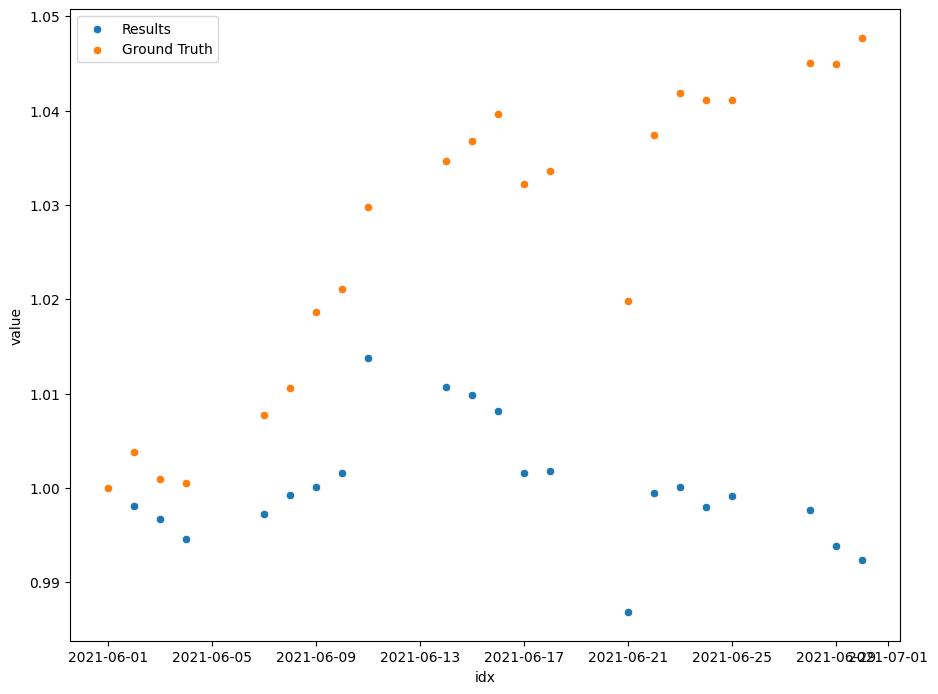

In [19]:
#fig, ax = plt.subplot(1)
fig = plt.figure(figsize=(10.708,8.2))
sns.scatterplot(x=df_results_norm.idx, y=df_results_norm.value, label='Results')
sns.scatterplot(x='ds', y=0, data=df_base, label='Ground Truth')
plt.show()

In [20]:
# self.output.to_pickle(self.save_path+'output.pkl')
# self.agg_results.to_pickle(self.save_path+'agg_results.pkl')
# self.baseline.to_pickle(self.save_path+'baseline.pkl')